# Overview
- nb002の改良
- nb005で作った、get_696_strategy_foldを使って、薬剤リークのないモデルを作成する

In [1]:
# gitのhash
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

a81131d


# Const

In [2]:
# basic
DEBUG = False
NB = '005'
PATH_TRAIN = '../data_ignore/input/train_features.csv'
PATH_TRAIN_SCORED = '../data_ignore/input/train_targets_scored.csv'
PATH_TRAIN_NONSCORED = '../data_ignore/input/train_targets_nonscored.csv'
PATH_SUB = '../data_ignore/input/sample_submission.csv'
PATH_TEST = '../data_ignore/input/test_features.csv'
SAVE_DIR = f'../data_ignore/output_nb/nb{NB}/'
PATH_GROUP = '../data_ignore/output_nb/nb003/group.csv'

In [3]:
settings_str = """
globals:
  seed: 2020
  device: cuda
  num_epochs: 45

dataset:
  name: 
  params:
    
split:
  name: KFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 512
    shuffle: True
    num_workers: 10
    pin_memory: True
    drop_last: True
  val:
    batch_size: 512
    shuffle: False
    num_workers: 10
    pin_memory: True
    drop_last: False

model:
  name: 
  params:

loss:
  name: BCELoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.005

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [4]:
import os
import time
import yaml
import random
import numpy as np
import pandas as pd
from fastprogress import progress_bar
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, GroupKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [5]:
import warnings
warnings.filterwarnings('ignore')

# My func

In [21]:
def preprocess(df_):
    df = df_.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
#     df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})
    del df['sig_id']
    return df

def remove_ctl_cp(features_, target_):
    features = features_.copy()
    target = target_.copy()
#     bools = features['cp_type'] != 'ctl_vehicle'
    bools = features['cp_type'] != 1
    features = features[bools].reset_index(drop=True)
    features = features.drop(['cp_type'], axis=1).values
    target = target[bools].reset_index(drop=True).values
    return features, target

def add_ctl_cp_oof(oof):
    oof_new = np.zeros_like(train_targets).astype(float)
    bools = train_features['cp_type'] != 'ctl_vehicle'
    oof_new[bools, :] = oof
    return oof_new

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def get_696_strategy_fold(group, n_splits, seed=0):
    '''nb004'''
    
    # group == 0 (all_target=0)の分解
    mask_0 = group['group'] == 0
    group_0 = group[mask_0]
    splitter = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    df_fold_0 = pd.DataFrame()
    df_fold_0['fold'] = np.zeros(len(group_0)).astype(int)
    for i_fold, (idx_trn, idx_val)  in enumerate(splitter.split(group_0)):
        df_fold_0['fold'][idx_val] = int(i_fold + 1)

    # group != 0 の分解
    mask_not0 = group['group'] != 0
    group_not0 = group[mask_not0]
    splitter = GroupKFold(n_splits=n_splits)
    df_fold_not0 = pd.DataFrame()
    df_fold_not0['fold'] = np.zeros(len(group_not0)).astype(int)
    for i_fold, (idx_trn, idx_val)  in enumerate(splitter.split(group_not0, groups=group_not0['group'].values)):
        df_fold_not0['fold'][idx_val] = int(i_fold + 1)

    # fold情報の結合
    df_fold = pd.DataFrame()
    df_fold['sig_id'] = group['sig_id'].values
    df_fold['fold'] = np.zeros(len(group)).astype(int)
    df_fold['fold'][mask_0.values] = df_fold_0['fold'].values
    df_fold['fold'][mask_not0.values] = df_fold_not0['fold'].values
    return df_fold

In [7]:
class MoaModel(nn.Module):
    def __init__(self, num_columns):
        super(MoaModel, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_columns)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_columns, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.sigmoid(self.dense3(x))
        
        return x

In [8]:
class MoaDataset(Dataset):
    def __init__(self, df, targets, mode):
        self.mode = mode
        self.df = df
#         self.targets = targets
        if mode=='train':
            self.targets = targets
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            return torch.FloatTensor(self.df[idx]), torch.FloatTensor(self.targets[idx])
        elif self.mode == 'val':
            return torch.FloatTensor(self.df[idx]), 0

In [9]:
def mean_log_loss(y_true, y_pred):
    metrics = []
    for i, target in enumerate(target_cols):
        metrics.append(log_loss(y_true[:, i], y_pred[:, i].astype(float), labels=[0,1]))
    return np.mean(metrics)

In [10]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
#         self.best_state_dict = {}
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        if not DEBUG:
            torch.save(model.state_dict(), self.path)
#         self.best_state_dict = model.state_dict()
        self.val_loss_min = val_loss

In [11]:
def train_model(model, device, train_loader, optimizer, scheduler, criterion):
    model.train()
    running_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() / len(train_loader)
    scheduler.step()
    return running_loss

def get_epoch_loss_score(model, device, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    targets = []
    preds = []
    for i, (x, y) in enumerate(valid_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            pred = model(x)
            loss = criterion(pred, y)
        running_loss += loss.item() / len(valid_loader)
        targets.append(y)
        preds.append(pred)
    targets = torch.cat(targets, dim=0).cpu().numpy()
    preds = torch.cat(preds, dim=0).cpu().numpy()
    _mean_log_loss = mean_log_loss(targets, preds)
    return running_loss, _mean_log_loss, preds

# Preparation

set

In [12]:
settings = yaml.safe_load(settings_str)
seed_everything(settings['globals']['seed'])
sns.set()
sns.set_context('talk')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [13]:
if DEBUG:
    settings['split']['params']['n_splits'] = 2
    settings['globals']['num_epochs'] = 3

<br>

load dataset

In [14]:
train_features = pd.read_csv(PATH_TRAIN)
train_targets = pd.read_csv(PATH_TRAIN_SCORED)
group = pd.read_csv(PATH_GROUP)

In [15]:
if DEBUG:
    step = 99
    print(':: debug mode ::')
    train_features = train_features.iloc[::step, :]
    train_targets = train_targets.iloc[::step, :]
    group = group.iloc[::step, :]
#     test_features = test_features.iloc[::step, :]

<br>

preprocess

In [16]:
train = preprocess(train_features)
# test = preprocess(test_features).values

del train_targets['sig_id']

mask_trt = train_features['cp_type'] == 'trt_cp'
target_cols = [col for col in train_targets.columns]
train, targets = remove_ctl_cp(train, train_targets)

group = group[mask_trt].reset_index(drop=True)
# train_targets = train_targets.loc[train['cp_type']==0].reset_index(drop=True).values
# train = train.loc[train['cp_type']==0].reset_index(drop=True).values

In [17]:
print(f'train shape:         {train.shape}')
# print(f'test shape:          {test.shape}')
print(f'train_targets shape: {targets.shape}')

train shape:         (21948, 874)
train_targets shape: (21948, 206)


# Create model

In [18]:
n_splits = settings['split']['params']['n_splits']
n_epochs = settings['globals']['num_epochs']
# splitter = KFold(**settings['split']['params'])
device = settings['globals']['device']
criterion = criterion_ = nn.__getattribute__(
    settings['loss']['name'])(**settings['loss']['params'])
df_fold = get_696_strategy_fold(group, n_splits)

----------------------------------------------------------------------------------------------------
:: start fold 1/5 at Tue Oct 20 21:38:12 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.43185   val_loss: 0.07004   mean_log_loss: 0.06645
Validation loss decreased (inf --> 0.070040).  Saving model ...
Epoch 02/45   loss: 0.04114   val_loss: 0.01184   mean_log_loss: 0.01180
Validation loss decreased (0.070040 --> 0.011836).  Saving model ...
Epoch 03/45   loss: 0.02573   val_loss: 0.00977   mean_log_loss: 0.00974
Validation loss decreased (0.011836 --> 0.009772).  Saving model ...
Epoch 04/45   loss: 0.02418   val_loss: 0.00873   mean_log_loss: 0.00869
Validation loss decreased (0.009772 --> 0.008734).  Saving model ...
Epoch 05/45   loss: 0.02338   val_loss: 0.00841   mean_log_loss: 0.00837
Validation loss decreased (0.008734 --> 0.008412).  Saving model ...
Epoch 06/45   loss: 0.02290   val_loss: 0.00

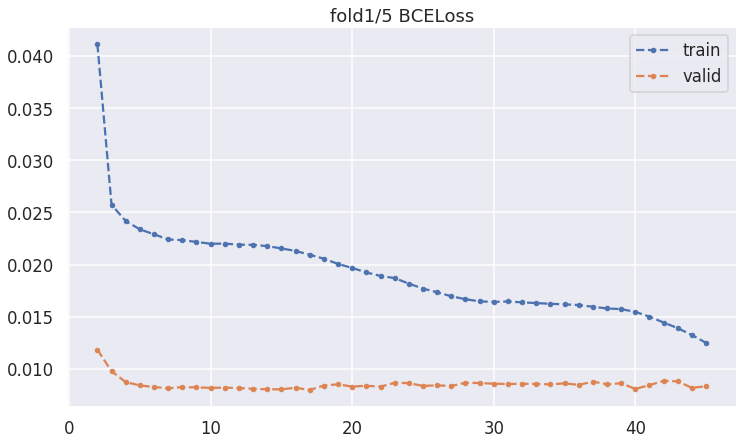



----------------------------------------------------------------------------------------------------
:: start fold 2/5 at Tue Oct 20 21:39:11 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.40862   val_loss: 0.06975   mean_log_loss: 0.06974
Validation loss decreased (inf --> 0.069753).  Saving model ...
Epoch 02/45   loss: 0.03652   val_loss: 0.04031   mean_log_loss: 0.04029
Validation loss decreased (0.069753 --> 0.040305).  Saving model ...
Epoch 03/45   loss: 0.02303   val_loss: 0.04274   mean_log_loss: 0.04274
EarlyStopping counter: 1 out of 30
Epoch 04/45   loss: 0.02122   val_loss: 0.04018   mean_log_loss: 0.04017
Validation loss decreased (0.040305 --> 0.040185).  Saving model ...
Epoch 05/45   loss: 0.02046   val_loss: 0.05050   mean_log_loss: 0.05049
EarlyStopping counter: 1 out of 30
Epoch 06/45   loss: 0.01990   val_loss: 0.04592   mean_log_loss: 0.04591
EarlyStopping counter: 2 out of 30
Ep

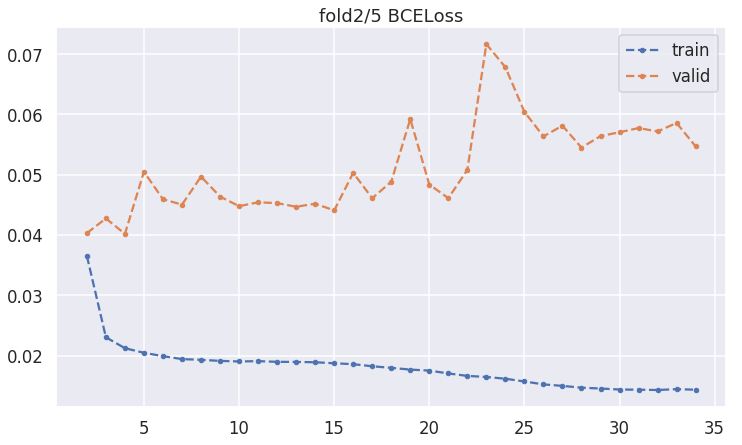



----------------------------------------------------------------------------------------------------
:: start fold 3/5 at Tue Oct 20 21:39:55 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.40826   val_loss: 0.06663   mean_log_loss: 0.06581
Validation loss decreased (inf --> 0.066625).  Saving model ...
Epoch 02/45   loss: 0.03553   val_loss: 0.02852   mean_log_loss: 0.02852
Validation loss decreased (0.066625 --> 0.028519).  Saving model ...
Epoch 03/45   loss: 0.02146   val_loss: 0.02816   mean_log_loss: 0.02817
Validation loss decreased (0.028519 --> 0.028162).  Saving model ...
Epoch 04/45   loss: 0.01971   val_loss: 0.02828   mean_log_loss: 0.02828
EarlyStopping counter: 1 out of 30
Epoch 05/45   loss: 0.01879   val_loss: 0.02851   mean_log_loss: 0.02851
EarlyStopping counter: 2 out of 30
Epoch 06/45   loss: 0.01831   val_loss: 0.02869   mean_log_loss: 0.02870
EarlyStopping counter: 3 out of 30
Ep

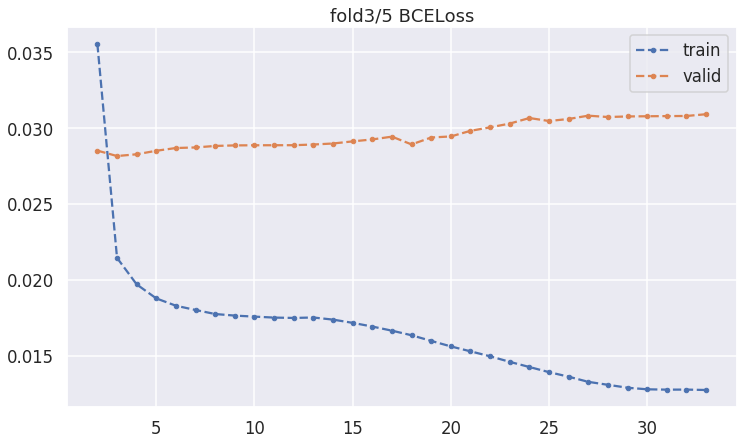



----------------------------------------------------------------------------------------------------
:: start fold 4/5 at Tue Oct 20 21:40:38 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.39581   val_loss: 0.07968   mean_log_loss: 0.06973
Validation loss decreased (inf --> 0.079677).  Saving model ...
Epoch 02/45   loss: 0.03452   val_loss: 0.02991   mean_log_loss: 0.02996
Validation loss decreased (0.079677 --> 0.029905).  Saving model ...
Epoch 03/45   loss: 0.02140   val_loss: 0.02925   mean_log_loss: 0.02930
Validation loss decreased (0.029905 --> 0.029249).  Saving model ...
Epoch 04/45   loss: 0.01966   val_loss: 0.02974   mean_log_loss: 0.02979
EarlyStopping counter: 1 out of 30
Epoch 05/45   loss: 0.01890   val_loss: 0.02978   mean_log_loss: 0.02984
EarlyStopping counter: 2 out of 30
Epoch 06/45   loss: 0.01821   val_loss: 0.03009   mean_log_loss: 0.03015
EarlyStopping counter: 3 out of 30
Ep

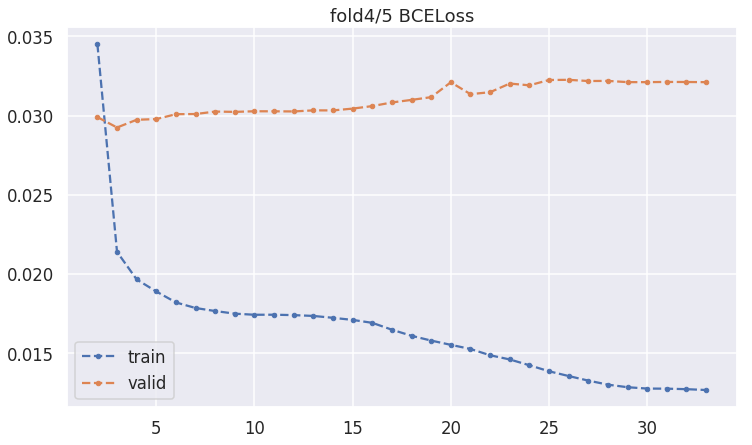



----------------------------------------------------------------------------------------------------
:: start fold 5/5 at Tue Oct 20 21:41:21 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.41745   val_loss: 0.07611   mean_log_loss: 0.07432
Validation loss decreased (inf --> 0.076111).  Saving model ...
Epoch 02/45   loss: 0.03508   val_loss: 0.02991   mean_log_loss: 0.03000
Validation loss decreased (0.076111 --> 0.029911).  Saving model ...
Epoch 03/45   loss: 0.02149   val_loss: 0.02953   mean_log_loss: 0.02962
Validation loss decreased (0.029911 --> 0.029526).  Saving model ...
Epoch 04/45   loss: 0.01971   val_loss: 0.02949   mean_log_loss: 0.02960
Validation loss decreased (0.029526 --> 0.029492).  Saving model ...
Epoch 05/45   loss: 0.01883   val_loss: 0.02968   mean_log_loss: 0.02979
EarlyStopping counter: 1 out of 30
Epoch 06/45   loss: 0.01832   val_loss: 0.02984   mean_log_loss: 0.02995
Ear

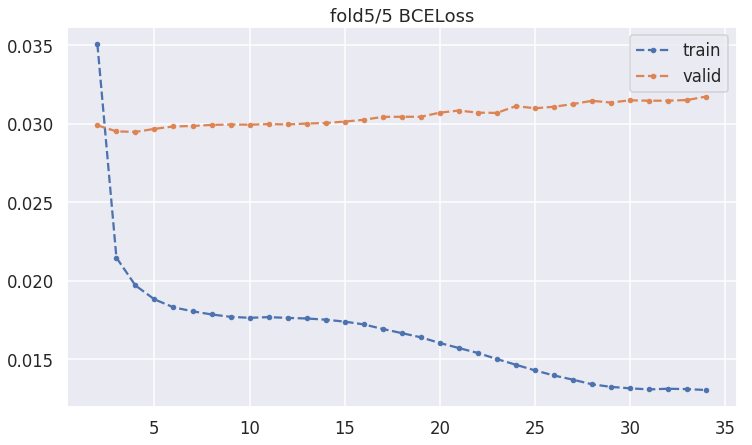



----------------------------------------------------------------------------------------------------
mean_log_loss(all fold): 0.027034 +- 0.010494
mean_log_loss(oof):      0.024916
----------------------------------------------------------------------------------------------------
CPU times: user 1min 23s, sys: 2min 16s, total: 3min 39s
Wall time: 3min 53s


In [20]:
%%time
mean_log_loss_list = []
# best_mean_log_loss = np.inf
oof = np.zeros_like(targets).astype(float)
# for n, (idx_trn, idx_val) in enumerate(splitter.split(train, targets)):
for n in range(n_splits):
    print('-'*100)
    print(f':: start fold {n+1}/{n_splits} at {time.ctime()} ::')
    print('-'*100)
    idx_val = df_fold['fold'].values == n + 1
    idx_trn = df_fold['fold'].values != n + 1
    X_trn, X_val = train[idx_trn, ], train[idx_val]
    y_trn, y_val = targets[idx_trn], targets[idx_val]

    train_set = MoaDataset(X_trn, y_trn, mode='train')
    val_set = MoaDataset(X_val, y_val, mode='train')

    dataloaders = {
        'train': DataLoader(train_set, **settings['loader']['train']),
        'val': DataLoader(val_set, **settings['loader']['val']),
    }

    model = MoaModel(train.shape[1]).to(device)
    checkpoint_path = f'{SAVE_DIR}Fold{n+1}of{n_splits}.pt'
    early_stopping = EarlyStopping(patience=30, verbose=True, path=checkpoint_path)
    optimizer = optim.__getattribute__(settings['optimizer']['name'])(
        model.parameters(), **settings['optimizer']['params'])
    scheduler = optim.lr_scheduler.__getattribute__(settings['scheduler']['name'])(
        optimizer, **settings['scheduler']['params'])
    best_valid_loss = np.inf
    best_mean_log_loss = np.inf
    best_preds = 0
    val_losses = []
    trn_losses = []
    for epoch in range(n_epochs):
        train_loss =  train_model(model, device, dataloaders['train'], optimizer, scheduler, criterion)
        valid_loss, _mean_log_loss, preds = get_epoch_loss_score(model, device, dataloaders['val'], criterion)

        trn_losses.append(train_loss)
        val_losses.append(valid_loss)
        print(f"Epoch {str(epoch+1).zfill(2)}/{n_epochs }   loss: {train_loss:5.5f}   val_loss: {valid_loss:5.5f}   mean_log_loss: {_mean_log_loss:5.5f}")
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        if valid_loss < best_valid_loss: 
            best_valid_loss = valid_loss
            best_mean_log_loss = _mean_log_loss
            best_preds = preds

    # result
    print(f':: best mean_log_loss: {best_mean_log_loss:5.5f} ::')
    mean_log_loss_list.append(best_mean_log_loss)
    oof[idx_val, :] = best_preds
    # plot
    x = np.arange(1, len(trn_losses)+1)
    plt.figure(figsize=(12, 7))
    plt.plot(x[1:], trn_losses[1:], '--.', label='train')
    plt.plot(x[1:], val_losses[1:], '--.', label='valid')
    plt.title(f"fold{n+1}/{n_splits} {settings['loss']['name']}")
    plt.legend()
    plt.show()
    print('\n')
# result
mean_mean_log_loss = np.mean(mean_log_loss_list)
std_mean_log_loss = np.std(mean_log_loss_list)
new_oof = add_ctl_cp_oof(oof)
oof_score = mean_log_loss(train_targets.values, new_oof)
print('-'*100)
print(f"mean_log_loss(all fold): {mean_mean_log_loss:5.6f} +- {std_mean_log_loss:5.6f}")
print(f"mean_log_loss(oof):      {oof_score:5.6f}")
print('-'*100)